In [1]:
# Disable warnings in Anaconda
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [3]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [4]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [5]:
data = pd.read_csv(DATA_PATH + "credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [6]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

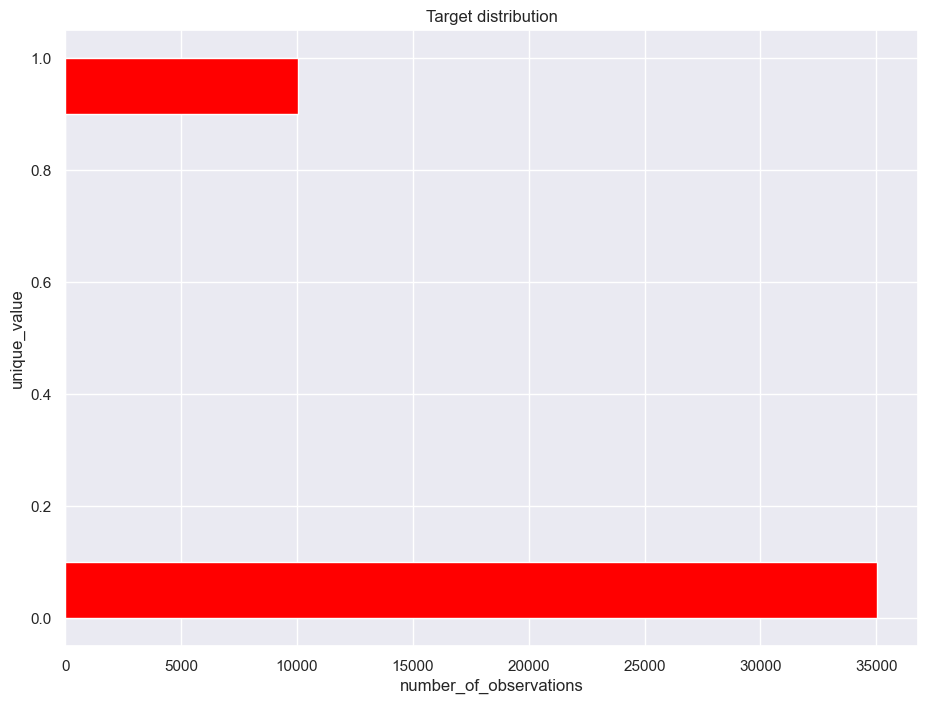

In [7]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [8]:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [9]:
table = fill_nan(data)

In [16]:
data.shape

(45063, 8)

In [10]:
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [11]:
def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries

In [32]:
# Save the data about the good and bad customers to split the dataset

bad_clients = data.loc[
    data["SeriousDlqin2yrs"] == 1, "age"
].values

# Set the seed for reproducibility of the results
np.random.seed(0)

bad_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(bad_clients, 1000)
]

print(
    "Service calls from bad: mean interval", stat_intervals(bad_mean_scores, 0.1)
)

Service calls from bad: mean interval [45.71379414 46.12700479]


**Logistic regression**

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [26]:
lr = LogisticRegression(random_state=5, class_weight="balanced")

In [27]:
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In [28]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [31]:
X = table.drop(["SeriousDlqin2yrs"], axis =1)
y = table["SeriousDlqin2yrs"]

grid_search = GridSearchCV(lr, parameters, n_jobs=-1, scoring="roc_auc", cv=skf)
grid_search = grid_search.fit(X, y)
grid_search.best_estimator_

/Users/valentinshapovalov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/valentinshapovalov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [33]:
grid_search.cv_results_["std_test_score"][1]

0.008137559189742445

In [34]:
grid_search.best_score_

0.8089120626797153

In [35]:
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C=0.001, random_state=5, class_weight="balanced")
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

pd.DataFrame(
    {"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}
).sort_values(by="coef", ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427
3,NumberOfTimes90DaysLate,0.516788
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558
6,NumberOfDependents,0.101443
2,DebtRatio,-0.024096
5,MonthlyIncome,-0.163146
0,age,-0.416702


In [37]:
#Use SoftMax function for evaluate DebtRatio
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

0.11426375283065286


**Random forest**

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced"
)

In [40]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

In [41]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

In [42]:
%%time
rf_grid_search = GridSearchCV(
    rf, parameters, n_jobs=-1, scoring="roc_auc", cv=skf, verbose=True
)
rf_grid_search = rf_grid_search.fit(X, y)
print(rf_grid_search.best_score_ - grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.026866482423537952
CPU times: user 2.25 s, sys: 215 ms, total: 2.46 s
Wall time: 40.5 s


In [43]:
independent_columns_names[
    np.argmin(rf_grid_search.best_estimator_.feature_importances_)
]

'NumberOfDependents'

In [44]:
pd.DataFrame(
    {
        "feat": independent_columns_names,
        "coef": rf_grid_search.best_estimator_.feature_importances_,
    }
).sort_values(by="coef", ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.300290
3,NumberOfTimes90DaysLate,0.278749
4,NumberOfTime60-89DaysPastDueNotWorse,0.156534
0,age,0.115860
2,DebtRatio,0.076082
5,MonthlyIncome,0.057994
6,NumberOfDependents,0.014491


**Bagging**

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

In [ ]:
bg = BaggingClassifier(
    LogisticRegression(class_weight="balanced"),
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
)
r_grid_search = RandomizedSearchCV(
    bg,
    parameters,
    n_jobs=-1,
    scoring="roc_auc",
    cv=skf,
    n_iter=20,
    random_state=1,
    verbose=True,
)
r_grid_search = r_grid_search.fit(X, y)

